# 1. Import Libraries and Load Files

In [28]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy import stats
import pingouin as pg

In [29]:
# Load business file
df_b = pd.read_csv('../datasets/business4.csv')

In [30]:
# Load review file
df_r = pd.read_parquet("../datasets/parquet_file/review_filtered.parquet")

# 2. Statistics

### (1) Stability Score

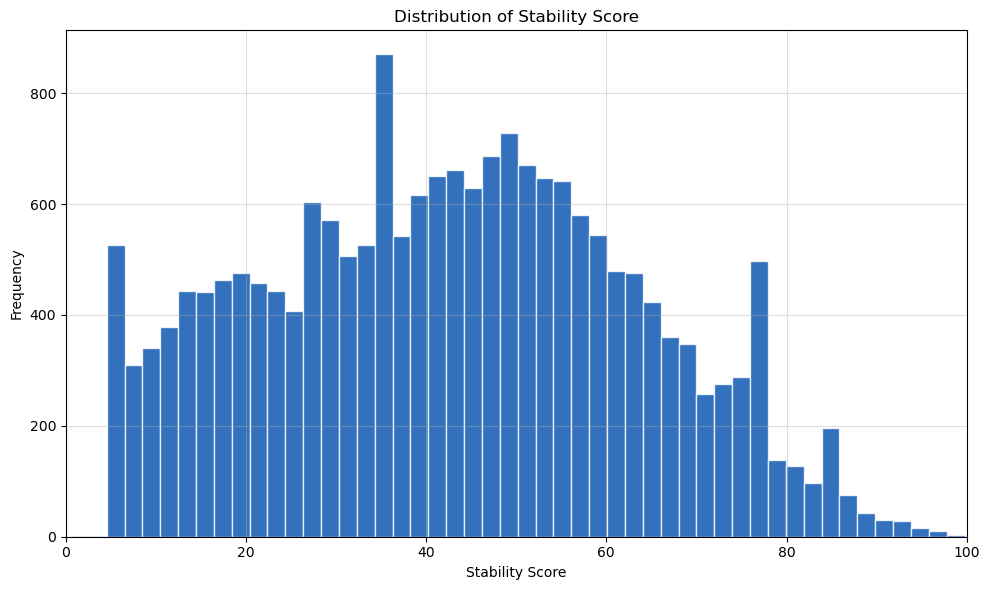

In [31]:
# -------------------------
# 1. Distribution
# -------------------------
plt.figure(figsize=(10, 6))

# Histogram
plt.hist(df_b['stability_score'], bins=50, color='#004ead', alpha=0.8, edgecolor='white')

# Labels / Styles
plt.title('Distribution of Stability Score')
plt.xlabel('Stability Score')
plt.ylabel('Frequency')

plt.xlim(0, 100)
plt.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()

C:\Users\toomu\AppData\Local\Temp\ipykernel_14528\1629522345.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


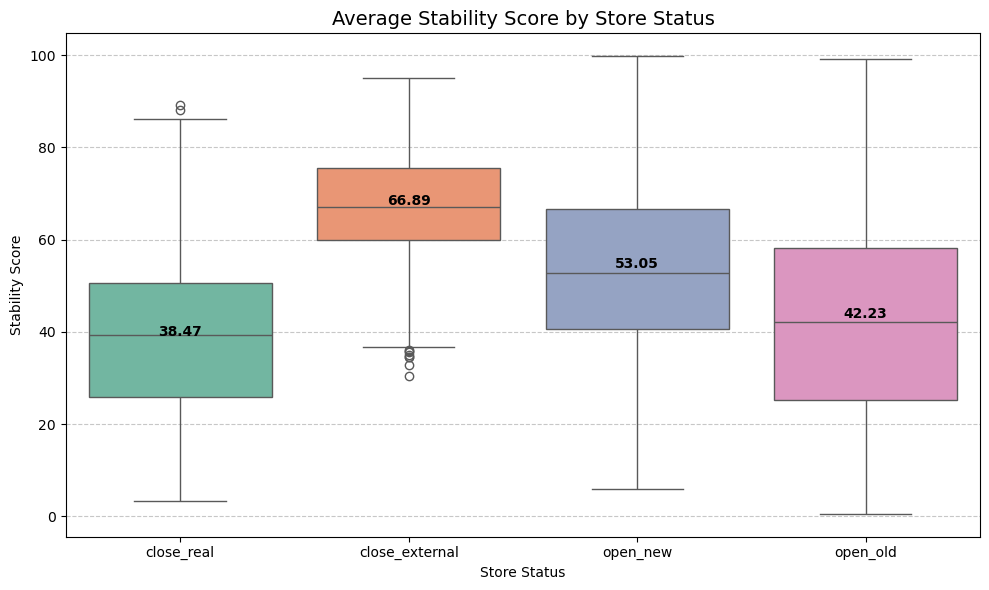

In [32]:
# -------------------------
# 2. EDA
# -------------------------
# Set plot style
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_b,
    x='store_status',
    y='stability_score',
    order=['close_real', 'close_external', 'open_new', 'open_old'],
    palette='Set2'
)

# Compute mean stability score per store_status
means = df_b.groupby('store_status')['stability_score'].mean()

# Display the mean values above each box
for i, status in enumerate(['close_real', 'close_external', 'open_new', 'open_old']):
    mean_val = means[status]
    plt.text(i, mean_val + 0.05,
             f'{mean_val:.2f}', 
             ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# Add plot title and axis labels
plt.title('Average Stability Score by Store Status', fontsize=14)
plt.xlabel('Store Status')
plt.ylabel('Stability Score')

# Add horizontal gridlines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [33]:
# -----------------------------
# 3. Statistics
# -----------------------------

# Convert store status into a binary target variable (1 = closed, 0 = open)
df_b["is_closed"] = (df_b["store_status"] == "close_real").astype(int)

# Train Logistic Regression Model
X = df_b[["stability_score"]]
X_sm = sm.add_constant(X)

y = df_b["is_closed"]

model = sm.Logit(y, X_sm).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.563651
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              is_closed   No. Observations:                19534
Model:                          Logit   Df Residuals:                    19532
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:                 0.01291
Time:                        18:44:21   Log-Likelihood:                -11010.
converged:                       True   LL-Null:                       -11154.
Covariance Type:            nonrobust   LLR p-value:                 1.394e-64
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4909      0.037    -13.444      0.000      -0.562      -0.419
stability_scor

c:\Users\toomu\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


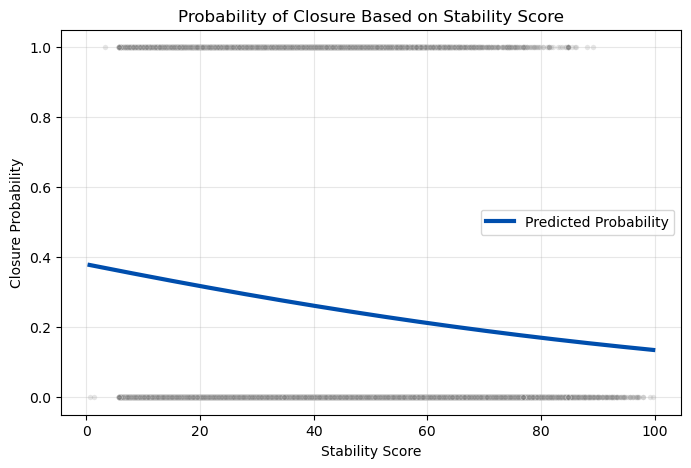

In [34]:
# -----------------------------
# 4. Visualization
# -----------------------------

model = LogisticRegression()
model.fit(X, y)

# Generate Predicted Probabilities
x_range = np.linspace(df_b["stability_score"].min(), df_b["stability_score"].max(), 200).reshape(-1, 1)
y_pred_prob = model.predict_proba(x_range)[:, 1]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_b, x="stability_score", y="is_closed", alpha=0.2, s=15, color="gray")
plt.plot(x_range, y_pred_prob, color="#004ead", linewidth=3, label="Predicted Probability")
plt.title("Probability of Closure Based on Stability Score")
plt.xlabel("Stability Score")
plt.ylabel("Closure Probability")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### (2) Loyalty_score

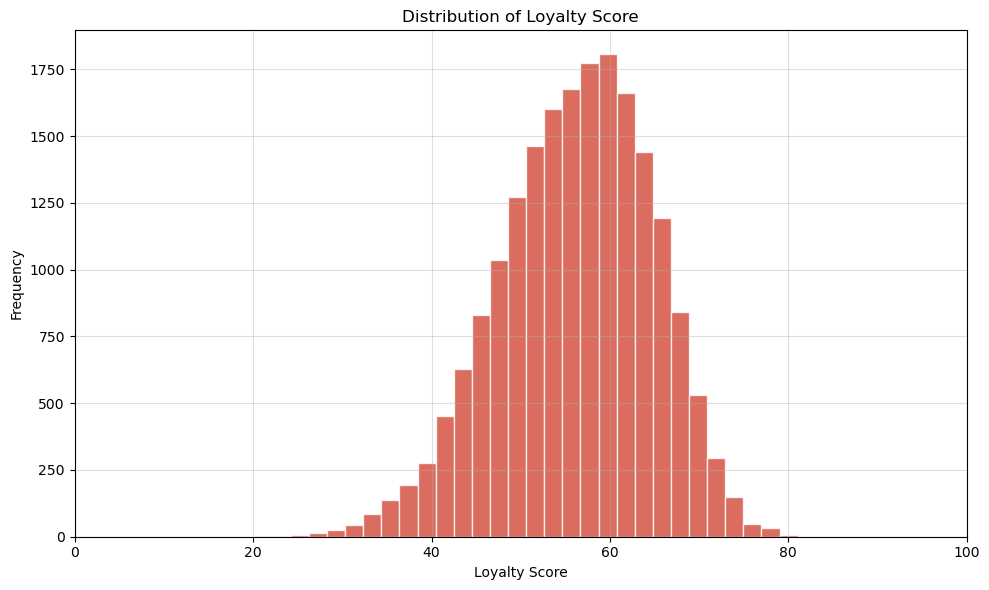

In [35]:
# -------------------------
# 1. Distribution
# -------------------------
# Check distribution
plt.figure(figsize=(10, 6))

# Histogram
plt.hist(df_b['loyalty_score'], bins=30, color='#d14938', alpha=0.8, edgecolor='white')

# Labels / Styles
plt.title('Distribution of Loyalty Score')
plt.xlabel('Loyalty Score')
plt.ylabel('Frequency')

plt.xlim(0, 100)
plt.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()

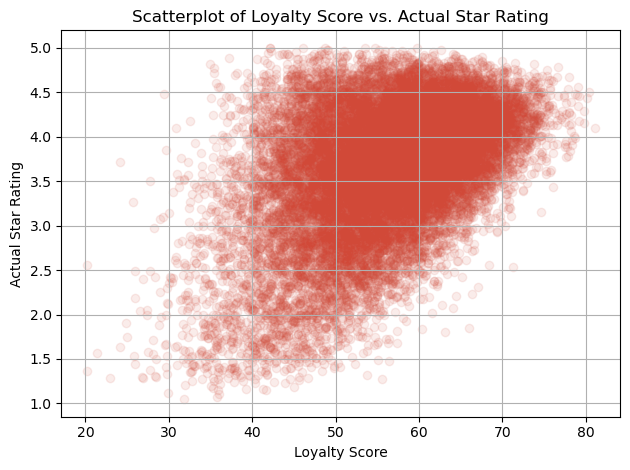

In [36]:
# -------------------------
# 2. EDA
# -------------------------

# Create the 'stars_real' column (average star rating for each business)
stars_real = df_r.groupby("business_id")["stars"].mean()
stars_df = pd.DataFrame({"stars_real": stars_real})

# Merge the average rating into df_b
df_b = df_b.merge(stars_df, on='business_id', how='left')

# Scatterplot
plt.scatter(df_b['loyalty_score'], df_b['stars_real'], color='#d14938', alpha=0.1)

# Plot settings
plt.title('Scatterplot of Loyalty Score vs. Actual Star Rating')
plt.xlabel('Loyalty Score')
plt.ylabel('Actual Star Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# -----------------------------
# 3. Statistics
# -----------------------------

# Divide loyalty_score into three groups (bottom 33%, middle 33%, top 33%)
df_b["loyalty_group"] = pd.qcut(df_b["loyalty_score"], q=3, labels=["Low", "Medium", "High"])

# Extract the distribution of actual star ratings for each group
loyalty_low = df_b.loc[df_b["loyalty_group"] == "Low", "stars_real"]
loyalty_mid = df_b.loc[df_b["loyalty_group"] == "Medium", "stars_real"]
loyalty_high = df_b.loc[df_b["loyalty_group"] == "High", "stars_real"]


In [38]:
# Test for normality (Shapiro–Wilk Test)
shapiro_test = stats.shapiro(df_b["stars_real"].dropna())
shapiro_test

c:\Users\toomu\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19534.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.9533402742938628), pvalue=np.float64(1.5527969861193736e-60))

In [39]:
# Test for homogeneity of variances (Levene's Test)
levene_val = stats.levene(loyalty_low, loyalty_mid, loyalty_high)
print(levene_val)

LeveneResult(statistic=np.float64(1222.341160615935), pvalue=np.float64(0.0))


In [40]:
# Welch's ANOVA test
welch = pg.welch_anova(data=df_b, dv='stars_real', between='loyalty_group')
welch

,Source,ddof1,ddof2,F,p-unc,np2
0,loyalty_group,2,12275.592822,1875.576657,0.0,0.161811


C:\Users\toomu\AppData\Local\Temp\ipykernel_14528\3655897221.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_b, x="loyalty_group", y="stars_real", palette=colors)


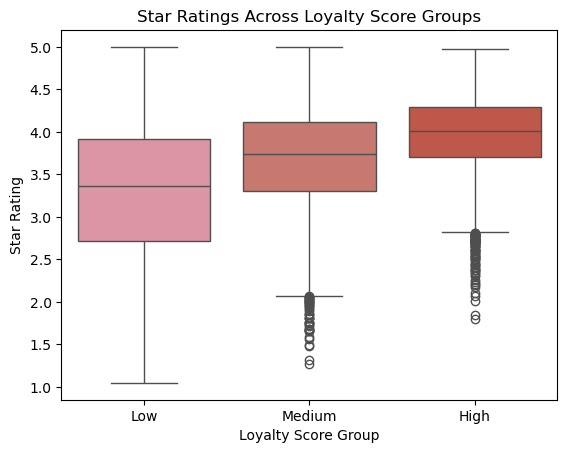

In [41]:
# -----------------------------
# 4. Visualization
# -----------------------------
colors = ['#e7899e', '#d56e61', '#d14938']
sns.boxplot(data=df_b, x="loyalty_group", y="stars_real", palette=colors)

plt.title("Star Ratings Across Loyalty Score Groups")
plt.xlabel("Loyalty Score Group")
plt.ylabel("Star Rating")

plt.show()

### (3) Reliability Score

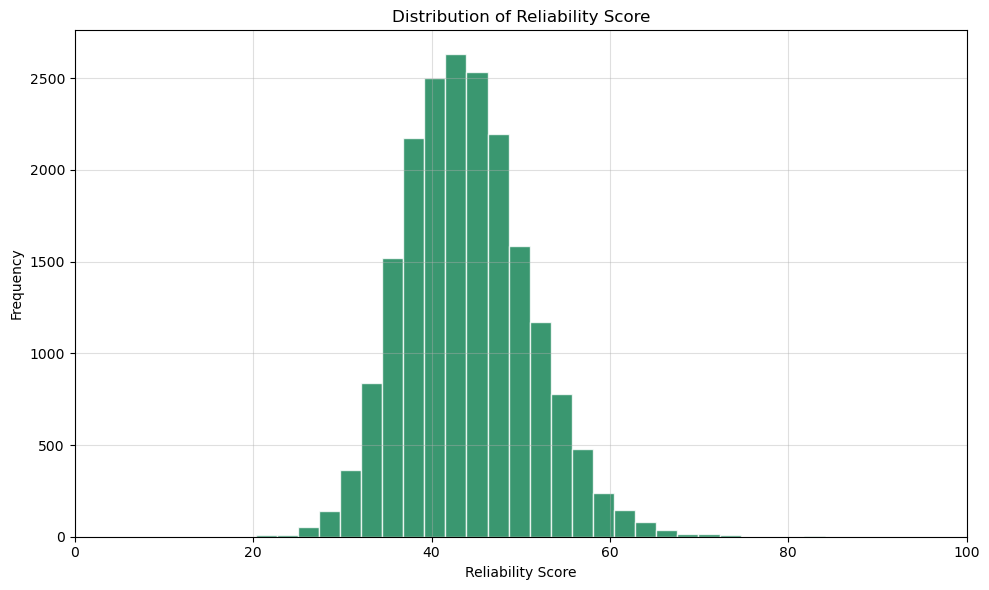

In [42]:
# -----------------------------
# 1. Distribution
# -----------------------------
# Check distribution
plt.figure(figsize=(10, 6))

# Histogram
plt.hist(df_b['reliability_score'], bins=30, color='#097d4c', alpha=0.8, edgecolor='white')

# Labels / Styles
plt.title('Distribution of Reliability Score')
plt.xlabel('Reliability Score')
plt.ylabel('Frequency')

plt.xlim(0, 100)
plt.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()

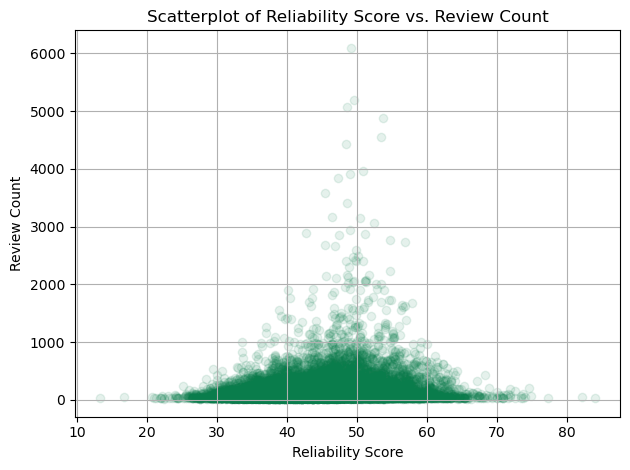

In [43]:
# -------------------------
# 2. EDA
# -------------------------

# Scatterplot
plt.scatter(df_b['reliability_score'], df_b['review_count'], color='#097d4c', alpha=0.1)

# Plot settings
plt.title('Scatterplot of Reliability Score vs. Review Count')
plt.xlabel('Reliability Score')
plt.ylabel('Review Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# -----------------------------
# 3. Statistics
# -----------------------------

# Divide reliability_score into three groups (bottom 33%, middle 33%, top 33%)
df_b["reliability_group"] = pd.qcut(df_b["reliability_score"], q=3, labels=["Low", "Medium", "High"])

# Extract the distribution of review count for each group
reliability_low = df_b.loc[df_b["reliability_group"] == "Low", "review_count"]
reliability_mid = df_b.loc[df_b["reliability_group"] == "Medium", "review_count"]
reliability_high = df_b.loc[df_b["reliability_group"] == "High", "review_count"]


In [45]:
# Test for normality (Shapiro–Wilk Test)
shapiro_test = stats.shapiro(df_b['review_count'].dropna())
shapiro_test

c:\Users\toomu\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19534.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.4556385864369381), pvalue=np.float64(6.170359116809281e-118))

In [46]:
# Test for homogeneity of variances (Levene's Test)
levene_val = stats.levene(reliability_mid, reliability_mid, reliability_high)
print(levene_val)

LeveneResult(statistic=np.float64(167.33314362583494), pvalue=np.float64(8.786180776513734e-73))


In [47]:
# Welch's ANOVA test
welch = pg.welch_anova(data=df_b, dv='review_count', between='reliability_group')
welch

,Source,ddof1,ddof2,F,p-unc,np2
0,reliability_group,2,11649.549286,284.951669,1.509599e-121,0.033736


C:\Users\toomu\AppData\Local\Temp\ipykernel_14528\2653928042.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_b, x="reliability_group", y="review_count", palette=colors)


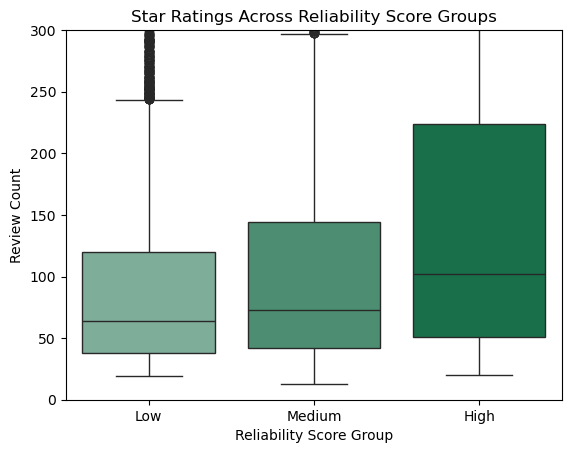

In [48]:
# -----------------------------
# 4. Visualization
# -----------------------------
colors = ['#76b59b', '#429974', '#097d4c']
sns.boxplot(data=df_b, x="reliability_group", y="review_count", palette=colors)

plt.title("Star Ratings Across Reliability Score Groups")
plt.xlabel("Reliability Score Group")
plt.ylabel("Review Count")
plt.ylim(0, 300) 

plt.show()